# FOSWEC BEM and impedance

 - SAND report: https://doi.org/10.2172/1717884
 - Journal paper: https://doi.org/10.1016/j.energy.2021.122485
 - YouTube video: https://youtu.be/OUxbaEC2K6Y

In [372]:
import autograd.numpy as np
import capytaine as cpy
import wecopttool as wot
wot.set_loglevel('INFO')
import gmsh
import pygmsh
import xarray as xr
import os
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import scipy.io as sio

# BEM
## Set up geometry and Capytaine

In [373]:
def flap(thickness=0.1, width=1, draft=1.15, xloc=0, ofst=0.1, mesh_size_factor=1):

    with pygmsh.occ.Geometry() as geom:
        gmsh.option.setNumber('Mesh.MeshSizeFactor', mesh_size_factor)
        flap = geom.add_box([-1*thickness/2, 0, 0],
                            [1*thickness, width, -draft])
        geom.translate(flap, [xloc, 0, 0])
        geom.translate(flap, [0, 0, ofst])
        mesh = geom.generate_mesh()
    return mesh

draft = 1.15
spacing = 1.44

mesh = flap(mesh_size_factor=0.65)
mesh.write('foswec_capytaine_one_flap.stl')
fb = cpy.FloatingBody.from_meshio(mesh)
fb.keep_immersed_part()
my_axis = cpy.meshes.geometry.Axis((0, 1, 0), 
                                   point=(0, 0, -1*draft))
fb.add_rotation_dof(axis=my_axis, name='rot_about_shaft')
array = fb.assemble_regular_array(distance=spacing, nb_bodies=(2, 1))

array.dofs['bow'] = array.dofs.pop('0_0__rot_about_shaft')
array.dofs['aft'] = array.dofs.pop('1_0__rot_about_shaft')
# array.show()

Warning: STL can only write triangle cells. Discarding vertex, tetra, line.

INFO:capytaine.bodies.bodies:Stored 804 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: fb_20230327214318897695.
INFO:capytaine.bodies.bodies:Clipping fb_20230327214318897695 with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.bodies.bodies:New floating body: 0_0+1_0.


## Animation to check DOFs

In [374]:
animation = array.animate(motion={ i : 0.2 for i in array.dofs.keys() }, loop_duration=1.0)
animation.save('foswec_capytaine.ogv', camera_position=[-5, -5, 5], resolution=(int(10e2),int(10e2)))

INFO:capytaine.ui.vtk.animation:Precompute motions of line_of_fb_20230327214318897695_mesh before animation.


## Run Capytaine

In [375]:
f1 = 0.0125
nfreq = 60
freq = wot.frequency(f1, nfreq, False) # False -> no zero frequency
file_name = 'foswec_capytaine.nc'
if not os.path.isfile(file_name):
    bem_data = wot.run_bem(array, freq)
else:
    bem_data = wot.read_netcdf(file_name)
bem_data

<xarray.Dataset>
Dimensions:              (radiating_dof: 2, influenced_dof: 2, omega: 60,
                          wave_direction: 1)
Coordinates:
  * radiating_dof        (radiating_dof) object 'bow' 'aft'
  * influenced_dof       (influenced_dof) object 'bow' 'aft'
  * omega                (omega) float64 0.07854 0.1571 0.2356 ... 4.634 4.712
  * wave_direction       (wave_direction) float64 0.0
    g                    float64 9.81
    rho                  float64 1.025e+03
    body_name            <U41 'array_of_fb_20230327210526733813_immersed'
    water_depth          float64 inf
Data variables:
    impedance            (radiating_dof, influenced_dof, omega) complex128 (1...
    added_mass           (omega, radiating_dof, influenced_dof) float64 365.4...
    radiation_damping    (omega, radiating_dof, influenced_dof) float64 1.383...
    diffraction_force    (omega, wave_direction, influenced_dof) complex128 (...
    Froude_Krylov_force  (omega, wave_direction, influenced_dof) complex128 0...

## Calculate impedance

In [376]:
stiffness = wot.hydrostatics.stiffness_matrix(array).values

rho = 1e3
m = fb.volume * rho * 0.9 # just less than neutrally buoyant
Ixx_center = 1/12 * m * draft
Ixx_shaft = Ixx_center + m*draft/2
inertia = Ixx_shaft * np.eye(2)

hydro = wot.linear_hydrodynamics(bem_data=bem_data, 
                              inertia_matrix=inertia, 
                              hydrostatic_stiffness=stiffness)

Zi = wot.hydrodynamic_impedance(hydro)
Zi.name = 'impedance'

INFO:wecopttool.hydrostatics:Using the geometric centroid as the center of gravity (COG).
INFO:wecopttool.hydrostatics:Using the center of gravity (COG) as the rotation center for hydrostatics.
INFO:capytaine.bodies.bodies:Clipping array_of_fb_20230327214318897695_immersed with respect to Plane(normal=[0. 0. 1.], point=[0. 0. 0.])
INFO:capytaine.meshes.clipper:Clipping fb_20230327214318897695_mesh by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.
INFO:capytaine.meshes.clipper:Clipping repetition_1_of_fb_20230327214318897695_mesh by Plane(normal=[0. 0. 1.], point=[0. 0. 0.]): no action.


## Save dataset to netCDF

In [377]:
Zi

<xarray.DataArray 'impedance' (radiating_dof: 2, influenced_dof: 2, omega: 60)>
array([[[ 1.38297852e-09-8.37683745e+03j,
          1.74376185e-07-4.13789134e+03j,
          2.96521709e-06-2.70232756e+03j,
          2.21657352e-05-1.96768892e+03j,
          1.05494097e-04-1.51296421e+03j,
          3.77263150e-04-1.19800566e+03j,
          1.10819037e-03-9.63146311e+02j,
          2.81137820e-03-7.78117299e+02j,
          6.38405042e-03-6.26138358e+02j,
          1.32725690e-02-4.97437043e+02j,
          2.57477944e-02-3.85440416e+02j,
          4.69498290e-02-2.86004352e+02j,
          8.22056536e-02-1.96435265e+02j,
          1.36439813e-01-1.13547134e+02j,
          2.19076740e-01-3.67715099e+01j,
          3.41855978e-01+3.53556491e+01j,
          5.20218408e-01+1.03820766e+02j,
          7.67414957e-01+1.69725108e+02j,
          1.10876423e+00+2.32985294e+02j,
          1.57405265e+00+2.94343384e+02j,
...
          2.21592806e+02+1.65738121e+03j,
          2.71555540e+02+1.74320825e+03j,
          3.32798455e+02+1.82957919e+03j,
          4.04709668e+02+1.91419172e+03j,
          4.94982112e+02+1.99532844e+03j,
          6.06331215e+02+2.06473363e+03j,
          7.33191874e+02+2.11350569e+03j,
          8.68129561e+02+2.14097999e+03j,
          1.00990376e+03+2.13537946e+03j,
          1.14118805e+03+2.08768330e+03j,
          1.24733552e+03+2.01420755e+03j,
          1.32108723e+03+1.92844995e+03j,
          1.35524215e+03+1.83458486e+03j,
          1.35285503e+03+1.74831234e+03j,
          1.33071934e+03+1.68648299e+03j,
          1.29071091e+03+1.65109758e+03j,
          1.23607718e+03+1.63906578e+03j,
          1.18278323e+03+1.65279351e+03j,
          1.13533755e+03+1.69554956e+03j,
          1.09006251e+03+1.76629778e+03j]]])
Coordinates:
  * radiating_dof   (radiating_dof) object 'bow' 'aft'
  * influenced_dof  (influenced_dof) object 'bow' 'aft'
    g               float64 9.81
    rho             float64 1.025e+03
    body_name       <U41 'array_of_fb_20230327210526733813_immersed'
    water_depth     float64 inf
  * omega           (omega) float64 0.07854 0.1571 0.2356 ... 4.555 4.634 4.712

In [378]:
sio.savemat('foswec_capytaine.mat',
            mdict={'Hexc':(hydro['Froude_Krylov_force'] + hydro['diffraction_force']).squeeze().values,
                   'Zi':Zi.values,
                   'radiation_damping':hydro['radiation_damping'].values,
                   'added_mass':hydro['added_mass'].values,
                   'omega':hydro['omega'].values,
                   'mass':hydro['inertia_matrix'].values,
                   'hydrostatic_stiffness':hydro['hydrostatic_stiffness'].values
                   },
            do_compression=True,
)

In [379]:
ds = xr.merge([Zi, bem_data])
wot.write_netcdf('foswec_capytaine.nc',ds)

## Plot impedance magnitude

In [380]:
# Zi[0,1,:] = 0*Zi[0,1,:]
# Zi[1,0,:] = 0*Zi[0,1,:]

# Zi[0,0,:] = Zi[0,0,:]
# Zi[1,1,:] = Zi[0,0,:]

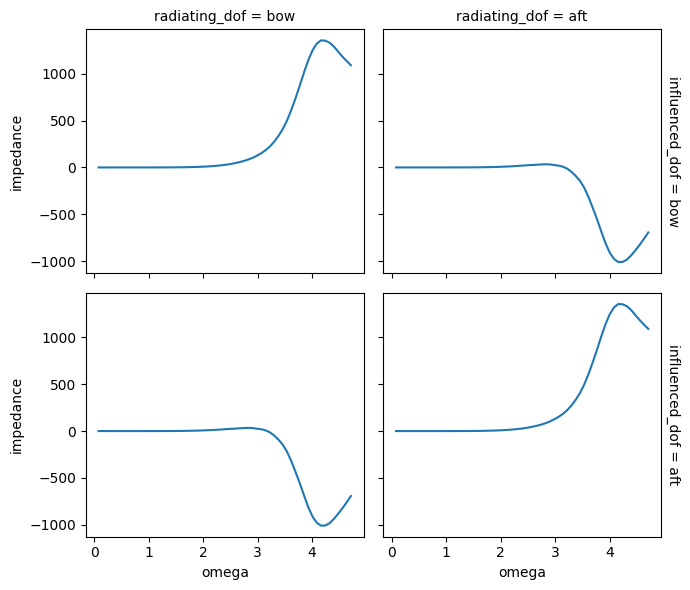

In [381]:
(np.real(Zi.squeeze())).plot(col='radiating_dof', row='influenced_dof')

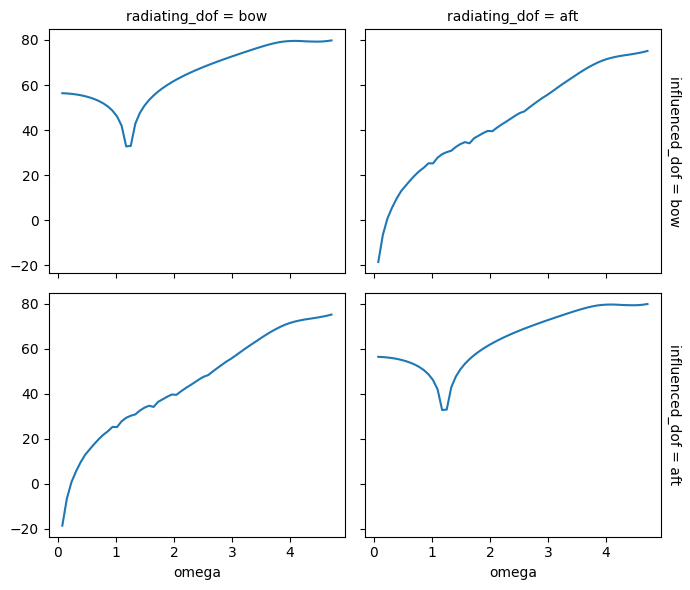

In [382]:
(20*np.log10(np.abs(Zi.squeeze()*1j*Zi.omega))).plot(col='radiating_dof', row='influenced_dof')

Text(0.5, 1.0, 'Excitation')

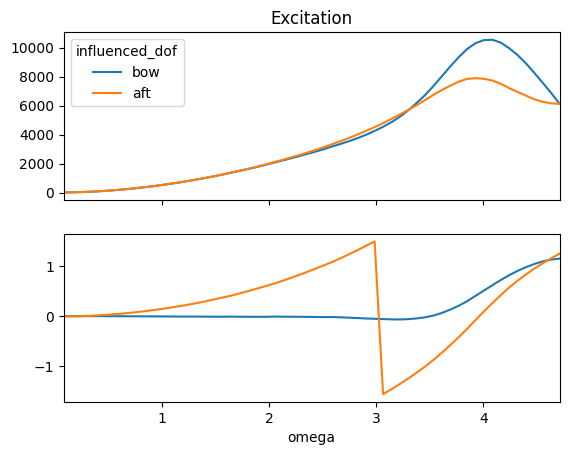

In [383]:
fig, ax = plt.subplots(nrows=2,
                       sharex=True)
exc = (hydro['diffraction_force'] + hydro['Froude_Krylov_force']).squeeze()
np.abs(exc).plot(hue='influenced_dof', ax=ax[0])
np.arctan(np.real(exc)/np.imag(exc)).plot(hue='influenced_dof', ax=ax[1], add_legend=False)

for axi in ax:
    axi.set_title('')
    axi.label_outer()
    axi.autoscale(enable=True, axis='x', tight=True)

ax[0].set_title('Excitation')

# PTO

## Losses

In [384]:
winding_resistance = 1.082*1e-4
torque_coefficient = 0.943

def power_loss(speed, torque):
    return winding_resistance * (torque / torque_coefficient)**2 

## Controller

In [385]:
def my_controller(pto, wec, x_wec, x_opt, waves=None, nsubsteps=1):
    ndof = pto.ndof
    vel_td = pto.velocity(wec, x_wec, x_opt, waves, nsubsteps)
    pos_td = pto.position(wec, x_wec, x_opt, waves, nsubsteps)
    Kp = np.eye(2) * x_opt[0] + np.rot90(np.eye(2)) * x_opt[1]
    Ki = np.eye(2) * x_opt[2] + np.rot90(np.eye(2)) * x_opt[3]
    # Kp = np.reshape(x_opt[:4],(2,2))
    # Ki = np.reshape(x_opt[4:],(2,2))
    force_td = np.dot(vel_td,Kp) + np.dot(pos_td,Ki)
    return force_td

## Create object

In [386]:
ndof_pto = 2
pto = wot.pto.PTO(ndof=ndof_pto, 
                  kinematics=np.eye(ndof_pto),
                  controller=my_controller, 
                  impedance=None, #TODO
                  loss=power_loss, 
                  names=Zi.radiating_dof.values,
                  )

# WEC

## Constaints
Maybe constrain the mean power from each flap to be negative?

In [387]:
nsubsteps=2

def mean_power_pto(wec, x_wec, x_opt, waves):
    power_mech = (
        pto.velocity(wec, x_wec, x_opt, waves, nsubsteps) *
        pto.force(wec, x_wec, x_opt, waves, nsubsteps)
    )
    return -1*np.mean(power_mech, axis=1)

max_pos = 30*np.pi/180
def pto_pos(wec, x_wec, x_opt, waves):
    abs_pos = np.abs(pto.position(wec, x_wec, x_opt, waves, nsubsteps).flatten())
    return max_pos - abs_pos

contraints = [
    # {'type': 'ineq', 'fun': mean_power_pto,},
    # {'type': 'ineq', 'fun': pto_pos,},
    ]

## Create object

In [388]:
# wec = wot.WEC.from_bem(bem_data=bem_data,
#                        inertia_matrix=inertia,
#                        hydrostatic_stiffness=stiffness,
#                        f_add={'PTO': pto.force_on_wec},
#                     #    constraints=[{'type': 'ineq', 'fun': power_pto,},], #TODO
#                        )

wec = wot.WEC.from_impedance(freqs=hydro.omega.values/np.pi/2,
                             impedance=Zi.values,
                             exc_coeff=hydro['Froude_Krylov_force'] + hydro['diffraction_force'],
                             hydrostatic_stiffness=hydro['hydrostatic_stiffness'],
                             f_add={'PTO': pto.force_on_wec},
                             constraints=contraints,
                             dof_names=Zi.radiating_dof.values,
                             )

# Waves

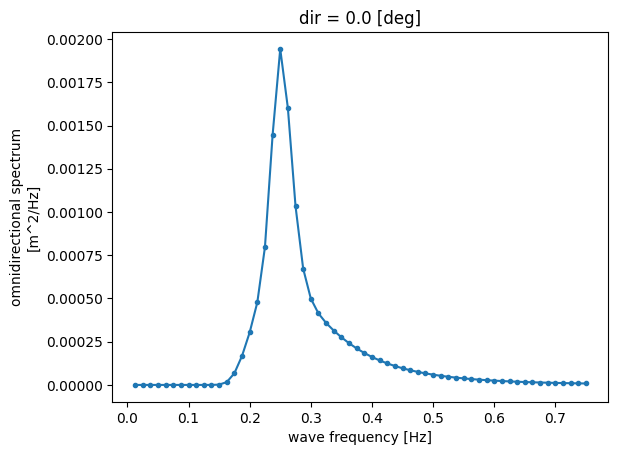

In [389]:
amplitude = 0.05/2
wavefreq = 1/4
phase = 0
wavedir = 0

# waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude, phase, wavedir)

spectrum = lambda f: wot.waves.jonswap_spectrum(freq=f, fp=wavefreq, hs=2*amplitude)
efth = wot.waves.omnidirectional_spectrum(f1, nfreq, spectrum, "JONSWAP")
waves = wot.waves.long_crested_wave(efth)
efth.plot(marker='.')

# Solve

In [390]:
# nstate_opt = 2*2*nfreq # two flaps, two components per freq
# nstate_opt = 2*2*2 # 2x2 mimo with PI controller
nstate_opt = 2*2 # 2x2 mimo, symmetric and rot90 symmetric with PI controller

results = wec.solve(
    waves,
    obj_fun=pto.average_power,
    nstate_opt=nstate_opt,
    optim_options={'maxiter': 100},
    x_wec_0=np.ones(wec.nstate_wec)*0.1,
    x_opt_0=np.ones(nstate_opt)*0.1,
    scale_x_wec=1e0,
    scale_x_opt=1e-2,
    scale_obj=1e-2,
    )

opt_mechanical_average_power = results.fun
print(f'Optimal average mechanical power: {opt_mechanical_average_power:.2f} W')

INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [1.80e+00, 8.31e-01, -1.77e+01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [2.20e+00, 1.70e-01, 5.19e+00]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [1.09e+00, 1.01e-01, 5.05e-01]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [9.06e-01, 7.85e-02, 5.66e-02]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [8.45e-01, 5.58e-02, 1.01e-03]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [8.42e-01, 5.20e-02, -3.05e-04]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [8.45e-01, 5.21e-02, -3.29e-04]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [8.58e-01, 5.23e-02, -5.36e-04]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [9.19e-01, 5.33e-02, -1.55e-03]
INFO:wecopttool.core:[max(x_wec), max(x_opt), obj_fun(x)]: [1.05e+00, 5.45e-02, -2.79e-03]
INFO:wecopttool.core:[max(x_wec)

Iteration limit reached    (Exit mode 9)
            Current function value: -0.01921888326273043
            Iterations: 100
            Function evaluations: 232
            Gradient evaluations: 100
Optimal average mechanical power: -1.92 W


# Gains

In [391]:
Kp = results['x'][-4:][0]*np.eye(2) + results['x'][-4:][1]*np.rot90(np.eye(2))
print(f'Kp\n{Kp}')

Ki = results['x'][-4:][2]*np.eye(2) + results['x'][-4:][3]*np.rot90(np.eye(2))
print(f'Kp\n{Ki}')

Kp
[[-405.01842309  404.32088638]
 [ 404.32088638 -405.01842309]]
Kp
[[  3.22396867 -15.30281623]
 [-15.30281623   3.22396867]]


# Results

In [392]:
pto_fdom, pto_tdom = pto.post_process(wec, results, waves)
wec_fdom, wec_tdom = wec.post_process(results, waves)
wec_tdom

<xarray.Dataset>
Dimensions:         (influenced_dof: 2, time: 120, type: 3, wave_direction: 1)
Coordinates:
  * influenced_dof  (influenced_dof) <U3 'bow' 'aft'
  * time            (time) float64 0.0 0.6667 1.333 2.0 ... 78.0 78.67 79.33
    omega           float64 4.712
    freq            float64 0.75
    period          float64 1.333
  * type            (type) object 'intrinsic_impedance' 'excitation' 'PTO'
  * wave_direction  (wave_direction) float64 0.0
Data variables:
    pos             (influenced_dof, time) float64 -1.384 -0.9342 ... -0.9117
    vel             (influenced_dof, time) float64 -0.02326 1.294 ... -1.3
    acc             (influenced_dof, time) float64 2.231 1.491 ... -0.1987 1.463
    force           (influenced_dof, type, time) float64 -50.9 -11.65 ... 1.805
    wave_elev       (wave_direction, time) float64 0.0002033 ... -0.008302
Attributes:
    time_created_utc:  2023-03-28 03:44:09.453199

## Time histories

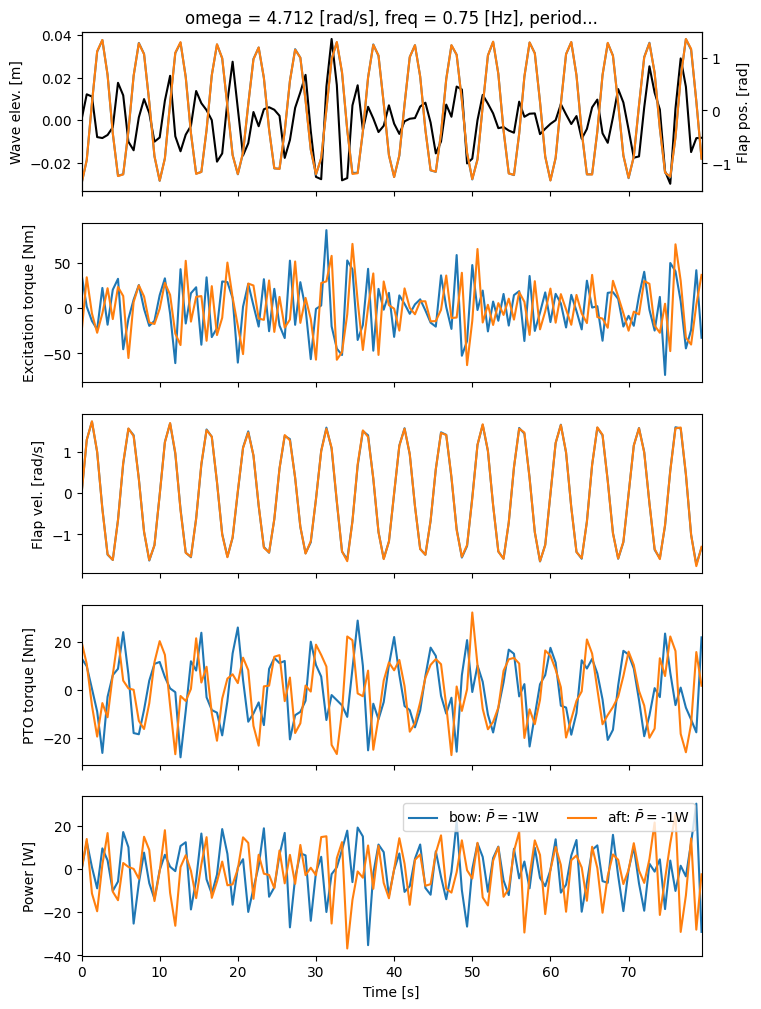

In [393]:
fig, ax = plt.subplots(nrows=5,
                       sharex=True,
                       figsize=(8,12))

# Wave elevation
wec_tdom.wave_elev.squeeze().plot(ax=ax[0], c='k')
ax[0].set_ylabel('Wave elev. [m]')
ax1 = ax[0].twinx()
wec_tdom.pos.plot(hue='influenced_dof', ax=ax1, add_legend=False)
ax1.set_ylabel('Flap pos. [rad]')

# Excitation
wec_tdom.force.sel(type='excitation').plot(hue='influenced_dof', ax=ax[1], add_legend=False)
ax[1].set_ylabel('Excitation torque [Nm]')

# Flap velocity
wec_tdom.vel.plot(ax=ax[2], hue='influenced_dof', add_legend=False)
ax[2].set_ylabel('Flap vel. [rad/s]')

# Torque
wec_tdom.force.sel(type='PTO').plot(ax=ax[3], hue='influenced_dof', add_legend=False)
ax[3].set_ylabel('PTO torque [Nm]')

# Power
pto_tdom.power.plot(ax=ax[4], hue='dof', add_legend=False)

p_mean = pto_tdom.power.mean('time')
p_mean

leg = []
for name, pow in zip(p_mean.dof.values, p_mean.values):
    leg.append(f'{name}: ' + '$\\bar{P}=$' + f'{pow:.0f}W')
ax[-1].legend(leg, ncol=2, loc=1)

for axi in ax:
    axi.label_outer()
    axi.set_title('')
    axi.autoscale(enable=True, axis='x', tight=True)